---
syncID: b0860577d1994b6e8abd23a6edf9e005
title: "Classify a Lidar Raster in Python"
description: "Read NEON lidar raster GeoTIFFs (e.g., CHM, slope, aspect) and create a classified raster object." 
dateCreated: 2018-07-04 
authors: Bridget Hass
contributors: Donal O'Leary, Max Burner
estimatedTime: 30 minutes
packagesLibraries: gdal, rasterio, requests
topics: lidar, raster, remote-sensing
languagesTool: Python
dataProduct: DP1.30003, DP3.30015, DP3.30024, DP3.30025
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Lidar/intro-lidar/classify-lidar-rasters/classify-chm.ipynb
tutorialSeries: intro-lidar-py-series
urlTitle: classify-chm-py
---

This tutorial covers how to read in a NEON lidar Canopy Height Model (CHM) geotiff file into a Python `rasterio` object, shows some basic information about the raster data, and then ends with classifying the CHM into height bins.

<div id="ds-objectives" markdown="1">

### Objectives

After completing this tutorial, you will be able to:

* User rasterio to read in a NEON lidar raster geotiff file
* Plot a raster tile and histogram of the data values
* Create a classified raster object using thresholds

### Install Python Packages

* **gdal** 
* **rasterio**
* **requests** 

### Download Data

For this lesson, we will read in a Canopy Height Model data collected at NEON's <a href="https://www.neonscience.org/field-sites/teak" target="_blank">Lower Teakettle (TEAK)</a> site in California. This data is downloaded in the first part of the tutorial, using the Python `requests` package.

</div>

In this tutorial, we will work with the NEON AOP L3 LiDAR ecoysystem structure (Canopy Height Model) data product. For more information about NEON data products and the CHM product DP3.30015.001, see the <a href="http://data.neonscience.org/data-products/DP3.30015.001" target="_blank">Ecosystem structure</a> data product page on NEON's Data Portal. 

First, let's import the required packages and set our plot display to be in-line:

In [1]:
import os
import copy
import requests
import numpy as np
import rasterio as rio
from rasterio.plot import show, show_hist
import matplotlib.pyplot as plt
%matplotlib inline

Next, let's download a file. For this tutorial, we will use the `requests` package to download a raster file from the public link where the data is stored. For simplicity, we will show how to download to a data folder in the working directory. You can move the data to a different folder, but be sure to update the path to your data accordingly. 

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

In [3]:
# public url where the CHM tile is stored
chm_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D17_TEAK_DP3_320000_4092000_CHM.tif"

# download the CHM tile
download_url(chm_url,'.\data')

# display the contents in the ./data folder to confirm the download completed
os.listdir('./data')

['NEON_D17_TEAK_DP3_320000_4092000_CHM.tif']

## Open a GeoTIFF with `rasterio`

Let's look at the TEAK Canopy Height Model (CHM) to start. We can open and read this in Python using the ```rasterio.open``` function:

In [4]:
# read the chm file (including the full path) to the variable chm_dataset
chm_name = chm_url.split('/')[-1]
chm_file = os.path.join(".\data",chm_name)
chm_dataset = rio.open(chm_file)

Now we can look at a few properties of this dataset to start to get a feel for the rasterio object:

In [5]:
print('chm_dataset:\n',chm_dataset)
print('\nshape:\n',chm_dataset.shape)
print('\nno data value:\n',chm_dataset.nodata)
print('\nspatial extent:\n',chm_dataset.bounds)
print('\ncoordinate information (crs):\n',chm_dataset.crs)

chm_dataset:
 <open DatasetReader name='.\data\NEON_D17_TEAK_DP3_320000_4092000_CHM.tif' mode='r'>

shape:
 (1000, 1000)

no data value:
 -9999.0

spatial extent:
 BoundingBox(left=320000.0, bottom=4092000.0, right=321000.0, top=4093000.0)

coordinate information (crs):
 PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## Plot the Canopy Height Map and Histogram

We can use rasterio's built-in functions `show` and `show_hist` to plot and visualize the CHM tile. It is often useful to plot a histogram of the geotiff data in order to get a sense of the range and distribution of values. 

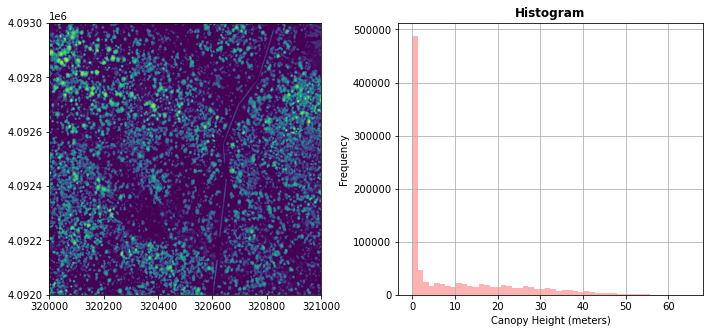

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
show(chm_dataset, ax=ax1);

show_hist(chm_dataset, bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.3, ax=ax2);
ax2.set_xlabel("Canopy Height (meters)");
ax2.get_legend().remove()

plt.show();

On your own, adjust the number of bins, and range of the y-axis to get a better sense of the distribution of the canopy height values. We can see that a large portion of the values are zero. These correspond to bare ground. Let's look at a  histogram and plot the data without these zero values. To do this, we'll remove all values > 1 m. Due to the vertical range resolution of the lidar sensor, data collected with the Optech Gemini sensor can only resolve the ground to within 2 m, so anything below that height will be rounded down to zero. Our newer sensors (Riegl Q780 and Optech Galaxy) have a higher resolution, so the ground can be resolved to within ~0.7 m.

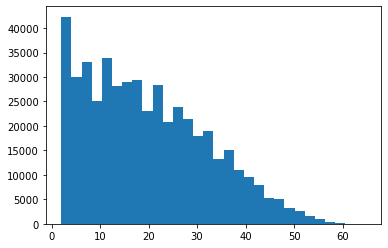

In [7]:
chm_data = chm_dataset.read(1)
valid_data = chm_data[chm_data>2]

plt.hist(valid_data.flatten(),bins=30);

From the histogram we can see that the majority of the trees are < 60m. But the taller trees are less common in this tile.

## Threshold Based Raster Classification
Next, we will create a classified raster object. To do this, we will use the numpy.where function to create a new raster based off boolean classifications. Let's classify the canopy height into five groups:
- Class 1: **CHM = 0 m** 
- Class 2: **0m < CHM <= 15m**
- Class 3: **10m < CHM <= 30m**
- Class 4: **20m < CHM <= 45m**
- Class 5: **CHM > 45m**

We can use `np.where` to find the indices where the specified criteria is met. 

In [8]:
chm_reclass = chm_data.copy()
chm_reclass[np.where(chm_data==0)] = 1 # CHM = 0 : Class 1
chm_reclass[np.where((chm_data>0) & (chm_data<=15))] = 2 # 0m < CHM <= 10m - Class 2
chm_reclass[np.where((chm_data>15) & (chm_data<=30))] = 3 # 10m < CHM <= 20m - Class 3
chm_reclass[np.where((chm_data>30) & (chm_data<=45))] = 4 # 20m < CHM <= 30m - Class 4
chm_reclass[np.where(chm_data>45)] = 5 # CHM > 30m - Class 5

When we look at this variable, we can see that it is now populated with values between 1-5:

In [9]:
chm_reclass

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 4.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [4., 4., 4., ..., 2., 2., 2.],
       [3., 4., 4., ..., 2., 2., 2.],
       [3., 3., 4., ..., 2., 1., 1.]], dtype=float32)

Lastly we can use matplotlib to display this re-classified CHM. We will define our own colormap to plot these discrete classifications, and create a custom legend to label the classes. First, to include the spatial information in the plot, create a new variable called `ext` that pulls from the rasterio "bounds" field to create the extent in the expected format for plotting.

In [10]:
ext = [chm_dataset.bounds.left,
       chm_dataset.bounds.right,
       chm_dataset.bounds.bottom,
       chm_dataset.bounds.top]
ext

[320000.0, 321000.0, 4092000.0, 4093000.0]

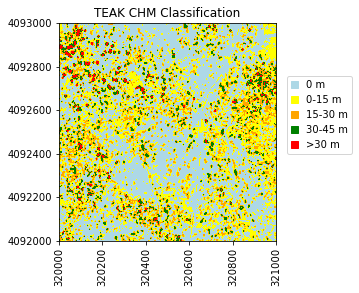

In [11]:
import matplotlib.colors as colors
plt.figure(); 
cmap_chm = colors.ListedColormap(['lightblue','yellow','orange','green','red'])
plt.imshow(chm_reclass,extent=ext,cmap=cmap_chm)
plt.title('TEAK CHM Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
class1 = mpatches.Patch(color='lightblue', label='0 m')
class2 = mpatches.Patch(color='yellow', label='0-15 m')
class3 = mpatches.Patch(color='orange', label='15-30 m')
class4 = mpatches.Patch(color='green', label='30-45 m')
class5 = mpatches.Patch(color='red', label='>30 m')

ax.legend(handles=[class1,class2,class3,class4,class5],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.);

<div id="ds-challenge" markdown="1">

**Challenge: Try Another Classification**

Create the following threshold classified outputs:

1. An NDVI raster where values are classified into the following categories:
- Low greenness: NDVI < 0.3
- Medium greenness: 0.3 < NDVI < 0.6
- High greenness: NDVI > 0.6

2. A classified aspect raster where the data is grouped into North and South facing slopes (or all four cardinal directions): 
- North: 0-45 & 315-360 degrees 
- South: 135-225 degrees

</div>